In [1]:
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from vision import WIDTH, TargetDetector, TargetDetectorMobileNet
from board import Board
from motor_controller import Direction, MotorController
import time
from typing import Optional, Tuple
from timer import timer

In [ ]:
@timer
def get_target(detector: TargetDetector) -> Optional[Tuple[int, int]]:
    target = None
    counter = 0
    while (not target) and (counter < 5):
        time.sleep(0.05)
        target = detector.get_target()
        counter += 1
    return target

In [ ]:
def _get_direction(target: int, width: int = WIDTH, side_ratio: float = 0.33) -> Direction:
    if target < side_ratio * width:
        return Direction.LEFT
    elif target > (1 - side_ratio) * width:
        return Direction.RIGHT
    else:
        return Direction.FORWARD

def get_direction(target: int, last_direction: Optional[Direction], width: int = WIDTH, side_ratio: float = 0.25) -> Direction:
    direction = _get_direction(target, width, side_ratio)
    if direction == last_direction and direction in (Direction.LEFT, Direction.RIGHT):
        return Direction.NONE
    return direction

In [ ]:
def get_turn_duration(target: int, width: int = WIDTH, side_ratio: float = 0.33, min_duration: float = 0.25, max_duration: float = 0.5) -> float:
    if target < side_ratio * width:
        return (1 - (target / (side_ratio * width))) * (max_duration - min_duration) + min_duration
    elif target > (1 - side_ratio) * width:
        return ((target - (1 - side_ratio) * width) / (side_ratio * width)) * (max_duration - min_duration) + min_duration
    else:
        # forward: 2 * max
        return 2 * max_duration
    

In [ ]:
board.stop()

In [ ]:
target_detector = TargetDetectorMobileNet(confidence=0.5)
board = Board()
motor_controller = MotorController(board)

logger = logging.getLogger('Driving')

try:
    target_detector.start()
    motor_controller.start()

    direction = None
    for i in range(500):
        target = target_detector.get_target()
        if target:
            x, _ = target
            direction = get_direction(x, direction, WIDTH)
            duration = get_turn_duration(x, WIDTH)
            logger.info('Target found: %s %s, %s', target, direction, duration)
            motor_controller.send_direction(direction, duration)
        time.sleep(0.05)

finally:
    motor_controller.stop()
    target_detector.stop()

In [3]:
board = Board()

In [4]:
import time

def get_distance(attempts: int = 2) -> float:
    sum = 0.0
    for _ in range(attempts):
        sum += board.get_sonic_distance()
        time.sleep(0.005) # enough time to have sound pass ~1.7m
    return sum / attempts

In [56]:
board.set_servo_angle(board.CMD_SERVO1, 90)

In [ ]:
import numpy as np

def get_distance_ahead(reverse: bool = False, min_angle: float = 45, max_angle: float = 135, lower_threshold: float = 5, upper_threshold: float = 70) -> np.array:
    distances= []
    angle_range = range(min_angle, max_angle + 1, 1) if not reverse else range(max_angle, min_angle - 1, -1)
    for angle in angle_range:
        board.set_servo_angle(board.CMD_SERVO1, angle)
        distance = get_distance()
        if (distance > lower_threshold and distance < upper_threshold):
            distances.append((angle, distance))
    coordinates = np.array([ [ np.cos(np.radians(angle)) * distance, np.sin(np.radians(angle)) * distance ] for (angle, distance) in distances ])
    return coordinates

In [34]:
import numpy as np
from collections import defaultdict

@timer
def get_distance_ahead_smoothed(reverse: bool = False, min_angle: float = 60, max_angle: float = 120, lower_threshold: float = 5, upper_threshold: float = 70, variance_threshold: float = 0.3, measuring_range: int = 7) -> np.array:
    distances = defaultdict(list)
    angle_range = range(min_angle, max_angle + 1, 1) if not reverse else range(max_angle, min_angle - 1, -1)
    for angle in angle_range:
        board.set_servo_angle(board.CMD_SERVO1, angle)
        distance = get_distance()
        if (distance > lower_threshold and distance < upper_threshold):
            for a in range(angle + (-1) * measuring_range, angle + measuring_range + 1):
                distances[a].append(distance)
    smoothed_distances = [ (k, np.array(v).mean()) for k, v in distances.items() if np.array(v).var() < variance_threshold ]
    coordinates = np.array([ [ np.cos(np.radians(angle)) * distance, np.sin(np.radians(angle)) * distance ] for (angle, distance) in smoothed_distances ])
    return coordinates

INFO:Timer:Latency: 1.052467 sec


Distance ahead: 26.577558206278464


INFO:Timer:Latency: 1.047622 sec


Distance ahead: 26.883985765652348


INFO:Timer:Latency: 1.047674 sec


Distance ahead: 27.35221966075916


INFO:Timer:Latency: 1.047671 sec


Distance ahead: 26.959008709078844


INFO:Timer:Latency: 1.047486 sec


Distance ahead: 27.535685662018153


INFO:Timer:Latency: 1.049906 sec


Distance ahead: 26.74083712477695


INFO:Timer:Latency: 1.047517 sec


Distance ahead: 27.473968902122913


INFO:Timer:Latency: 1.047577 sec


Distance ahead: 26.782163693362627


INFO:Timer:Latency: 1.047419 sec


Distance ahead: 27.417019771882


INFO:Timer:Latency: 1.047652 sec


Distance ahead: 27.33084260898687


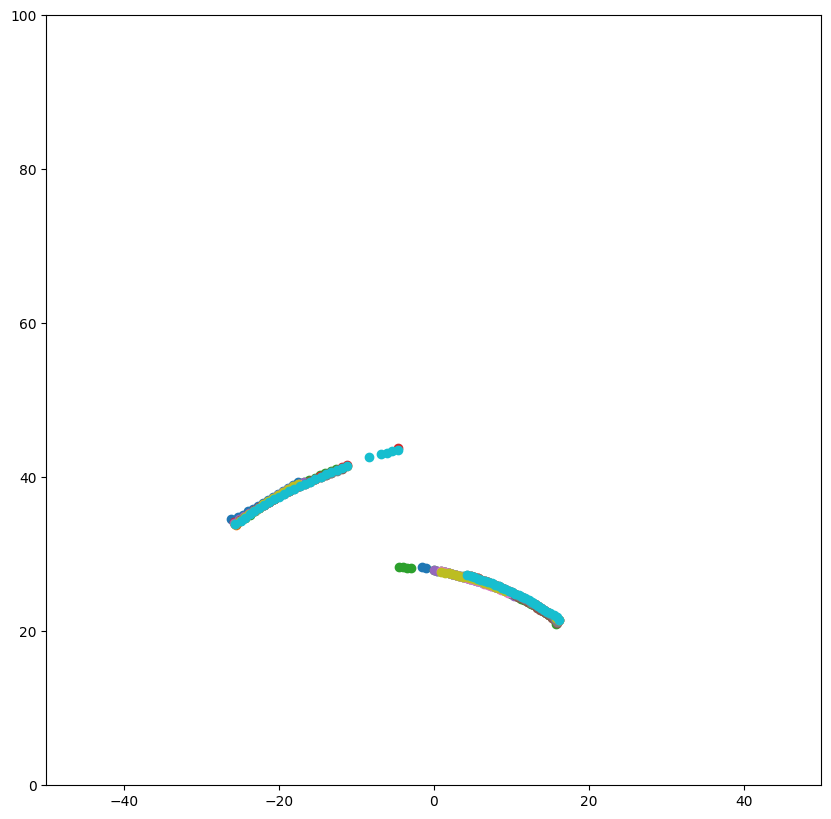

In [35]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

is_reversed = False
for i in range(10):
    coordinates = get_distance_ahead_smoothed(is_reversed)
    distance = np.median(coordinates[:, 1])
    print('Distance ahead:', distance)
    ax.scatter(coordinates[:, 0], coordinates[:, 1], label=f'Iteration {i+1}')
    ax.set_xlim(-50, 50)
    ax.set_ylim(0, 100)
    fig.canvas.draw()
    is_reversed = not is_reversed

plt.show()